In [1]:
!wget "https://huggingface.co/ngxson/demo_simple_rag_py/resolve/main/cat-facts.txt" -O cat-facts.txt


--2026-01-02 12:18:29--  https://huggingface.co/ngxson/demo_simple_rag_py/resolve/main/cat-facts.txt
Resolving huggingface.co (huggingface.co)... 3.163.189.74, 3.163.189.37, 3.163.189.90, ...
Connecting to huggingface.co (huggingface.co)|3.163.189.74|:443... connected.
HTTP request sent, awaiting response... 307 Temporary Redirect
Location: /api/resolve-cache/models/ngxson/demo_simple_rag_py/ccd6b7b72b52c7ca4e8f2a0a00b15c368d6ae294/cat-facts.txt?%2Fngxson%2Fdemo_simple_rag_py%2Fresolve%2Fmain%2Fcat-facts.txt=&etag=%22bc94ddd9483183e01bcf61e8bf9450fe3e09edb3%22 [following]
--2026-01-02 12:18:29--  https://huggingface.co/api/resolve-cache/models/ngxson/demo_simple_rag_py/ccd6b7b72b52c7ca4e8f2a0a00b15c368d6ae294/cat-facts.txt?%2Fngxson%2Fdemo_simple_rag_py%2Fresolve%2Fmain%2Fcat-facts.txt=&etag=%22bc94ddd9483183e01bcf61e8bf9450fe3e09edb3%22
Reusing existing connection to huggingface.co:443.
HTTP request sent, awaiting response... 200 OK
Length: 22657 (22K) [text/plain]
Saving to: ‘cat-fac

In [2]:
dataset = []
with open('/kaggle/working/cat-facts.txt', 'r') as file:
  dataset = file.readlines()
  print(f'Loaded {len(dataset)} entries')

Loaded 150 entries


In [3]:
# Kaggle-ready Knowledge Graph builder (no local downloads needed beyond pip installs)
# Paste this into a Kaggle Notebook cell.

# 1) Install deps (Kaggle allows pip installs in-notebook)
!pip -q install spacy networkx
!python -m spacy download en_core_web_sm -q

/usr/local/lib/python3.12/dist-packages/sqlalchemy/orm/query.py:195: SyntaxWarning: "is not" with 'tuple' literal. Did you mean "!="?
  if entities is not ():
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 79.1 MB/s eta 0:00:0000:0100:01
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


In [4]:
#Spacy Graph

import re
from typing import List, Optional, Tuple, Dict

import spacy
import networkx as nx


def normalize(s: str) -> str:
    s = re.sub(r"\s+", " ", s.strip())
    s = s.replace("’", "'")
    return s


def token_span_char(token) -> Tuple[int, int]:
    return token.idx, token.idx + len(token.text)


def pick_entity_for_span(
    ents_by_char: List[Tuple[int, int, str]],
    start: int,
    end: int
) -> Optional[str]:
    # If a token span overlaps an entity span, return the entity text.
    for s, e, text in ents_by_char:
        if not (end <= s or start >= e):  # overlap
            return text
    return None


def extract_entities(doc) -> Dict[str, Dict]:
    ents: Dict[str, Dict] = {}
    for ent in doc.ents:
        et = normalize(ent.text)
        if not et:
            continue
        if et not in ents:
            ents[et] = {"label": ent.label_, "count": 0}
        ents[et]["count"] += 1
    return ents


def extract_svo_relations(doc) -> List[Tuple[str, str, str]]:
    """
    Simple SVO extraction:
    - relation = verb lemma
    - subject deps: nsubj, nsubjpass
    - object deps: dobj, obj, attr, dative, oprd, plus pobj under preps
    """
    triples: List[Tuple[str, str, str]] = []
    ents_by_char = [(ent.start_char, ent.end_char, normalize(ent.text)) for ent in doc.ents]

    for token in doc:
        if token.pos_ != "VERB":
            continue

        subjects = [c for c in token.children if c.dep_ in ("nsubj", "nsubjpass")]
        objects = [c for c in token.children if c.dep_ in ("dobj", "obj", "attr", "dative", "oprd")]

        # prepositional objects
        for prep in [c for c in token.children if c.dep_ == "prep"]:
            for pobj in prep.children:
                if pobj.dep_ == "pobj":
                    objects.append(pobj)

        if not subjects or not objects:
            continue

        rel = normalize(token.lemma_)

        for s in subjects:
            s_start, s_end = token_span_char(s)
            subj_ent = pick_entity_for_span(ents_by_char, s_start, s_end)
            subj = subj_ent if subj_ent else normalize(s.text)

            for o in objects:
                o_start, o_end = token_span_char(o)
                obj_ent = pick_entity_for_span(ents_by_char, o_start, o_end)
                obj = obj_ent if obj_ent else normalize(o.text)

                # light filtering
                if len(subj) < 2 or len(obj) < 2:
                    continue
                if subj.lower() in ("it", "this", "that") or obj.lower() in ("it", "this", "that"):
                    continue

                triples.append((subj, rel, obj))

    return triples


def build_knowledge_graph(text: str, nlp=None) -> nx.MultiDiGraph:
    """
    Returns a MultiDiGraph:
      - nodes have attributes: type, ner_label, mention_count (if entity)
      - edges have attribute: relation
    """
    if nlp is None:
        nlp = spacy.load("en_core_web_sm")

    doc = nlp(text)
    entities = extract_entities(doc)
    triples = extract_svo_relations(doc)

    G = nx.MultiDiGraph()

    # entity nodes
    for ent_text, meta in entities.items():
        G.add_node(
            ent_text,
            type="entity",
            ner_label=meta["label"],
            mention_count=meta["count"],
        )

    # edges (create missing nodes as needed)
    for subj, rel, obj in triples:
        if subj not in G:
            G.add_node(subj, type="token_or_phrase")
        if obj not in G:
            G.add_node(obj, type="token_or_phrase")
        G.add_edge(subj, obj, relation=rel)

    return G

In [5]:
# Spacy Example
# -------------------
# Example usage
# -------------------
nlp = spacy.load("en_core_web_sm")

TEXT = """
In 2018, Orion Robotics partnered with Nova Dynamics to develop autonomous delivery drones.
The collaboration was announced at the Global Tech Summit in Berlin, where industry analysts
highlighted the growing influence of artificial intelligence in logistics.

Orion Robotics, founded by Elena Carter, focuses on robotic navigation systems and real-time
decision-making algorithms. Nova Dynamics, a multinational engineering firm headquartered
in Toronto, provides advanced sensor hardware and embedded control units.

During the first phase of the project, the joint team tested prototype drones across urban
environments in Germany and Canada. The drones used machine learning models trained on
millions of flight simulations. Engineers reported that the system reduced delivery times
by nearly 30 percent.

In 2020, Orion Robotics signed a separate agreement with Atlas Cloud Services to migrate
its data infrastructure to a distributed cloud platform. Atlas Cloud Services supplies
scalable computing resources for AI startups and research labs worldwide.

Meanwhile, Nova Dynamics expanded its research division and hired several former employees
from Helios Aerospace. These engineers brought experience in aerospace safety standards
and regulatory compliance.

By 2022, the delivery drone project attracted attention from government agencies.
The European Transport Authority evaluated the system for potential use in emergency
medical logistics. Analysts predicted that similar technologies would soon be adopted
by healthcare providers and retail companies.

Despite rapid progress, experts warned that ethical concerns and airspace regulations
could slow deployment. Industry leaders emphasized the importance of transparent governance
and international cooperation.
"""

G = build_knowledge_graph(TEXT, nlp=nlp)

print("Nodes:", G.number_of_nodes())
print("Edges:", G.number_of_edges())

# Show a few edges
for i, (u, v, data) in enumerate(G.edges(data=True)):
    if i >= 12:
        break
    print(f"{u} --[{data['relation']}]--> {v}")

# Save outputs to Kaggle working directory
nx.write_graphml(G, "/kaggle/working/knowledge_graph.graphml")
nx.write_gexf(G, "/kaggle/working/knowledge_graph.gexf")  # also useful for Gephi

print("Saved to /kaggle/working/: knowledge_graph.graphml, knowledge_graph.gexf")

Nodes: 46
Edges: 24
Nova Dynamics --[provide]--> hardware
Nova Dynamics --[expand]--> division
Atlas Cloud Services --[supply]--> resources
The European Transport Authority --[evaluate]--> system
The European Transport Authority --[evaluate]--> use
collaboration --[announce]--> the Global Tech Summit
analysts --[highlight]--> influence
Robotics --[focus]--> systems
Robotics --[sign]--> agreement
Robotics --[sign]--> 2020
team --[test]--> drones
team --[test]--> phase
Saved to /kaggle/working/: knowledge_graph.graphml, knowledge_graph.gexf


In [6]:
import matplotlib.pyplot as plt
import networkx as nx

def draw_knowledge_graph(
    G: nx.Graph,
    max_nodes: int = 80,
    node_size: int = 800,
    font_size: int = 8,
    figsize: tuple = (12, 8),
    seed: int = 42,
    show_edge_labels: bool = True,
):
    """
    Draw a (Multi)DiGraph knowledge graph with NetworkX + Matplotlib (Kaggle-friendly).

    - If the graph is large, it draws a subgraph of the top `max_nodes` nodes by degree.
    - Node labels are the node names.
    - Edge labels are the 'relation' attribute (optional).

    Returns: (fig, ax)
    """
    if G.number_of_nodes() == 0:
        raise ValueError("Graph is empty.")

    # If too large, keep only top nodes by degree
    H = G
    if G.number_of_nodes() > max_nodes:
        deg = dict(G.degree())
        keep = sorted(deg, key=deg.get, reverse=True)[:max_nodes]
        H = G.subgraph(keep).copy()

    # Layout
    pos = nx.spring_layout(H, seed=seed)

    fig, ax = plt.subplots(figsize=figsize)
    ax.axis("off")

    # Choose node sizes (optionally boost entities)
    sizes = []
    for n, data in H.nodes(data=True):
        if data.get("type") == "entity":
            sizes.append(int(node_size * 1.2))
        else:
            sizes.append(int(node_size * 0.8))

    # Draw nodes/edges
    nx.draw_networkx_nodes(H, pos, ax=ax, node_size=sizes)
    nx.draw_networkx_edges(H, pos, ax=ax, arrows=True, arrowstyle="-|>", arrowsize=12, width=1.2)
    nx.draw_networkx_labels(H, pos, ax=ax, font_size=font_size)

    # Edge labels: for MultiDiGraph, may be multiple edges per (u,v)
    if show_edge_labels:
        edge_labels = {}
        if isinstance(H, (nx.MultiDiGraph, nx.MultiGraph)):
            for u, v, k, data in H.edges(keys=True, data=True):
                rel = data.get("relation", "")
                if rel:
                    # If multiple relations between same nodes, concatenate
                    if (u, v) in edge_labels and rel not in edge_labels[(u, v)].split(" | "):
                        edge_labels[(u, v)] += f" | {rel}"
                    elif (u, v) not in edge_labels:
                        edge_labels[(u, v)] = rel
        else:
            for u, v, data in H.edges(data=True):
                rel = data.get("relation", "")
                if rel:
                    edge_labels[(u, v)] = rel

        if edge_labels:
            nx.draw_networkx_edge_labels(H, pos, ax=ax, edge_labels=edge_labels, font_size=max(6, font_size - 1))

    plt.tight_layout()
    return fig, ax





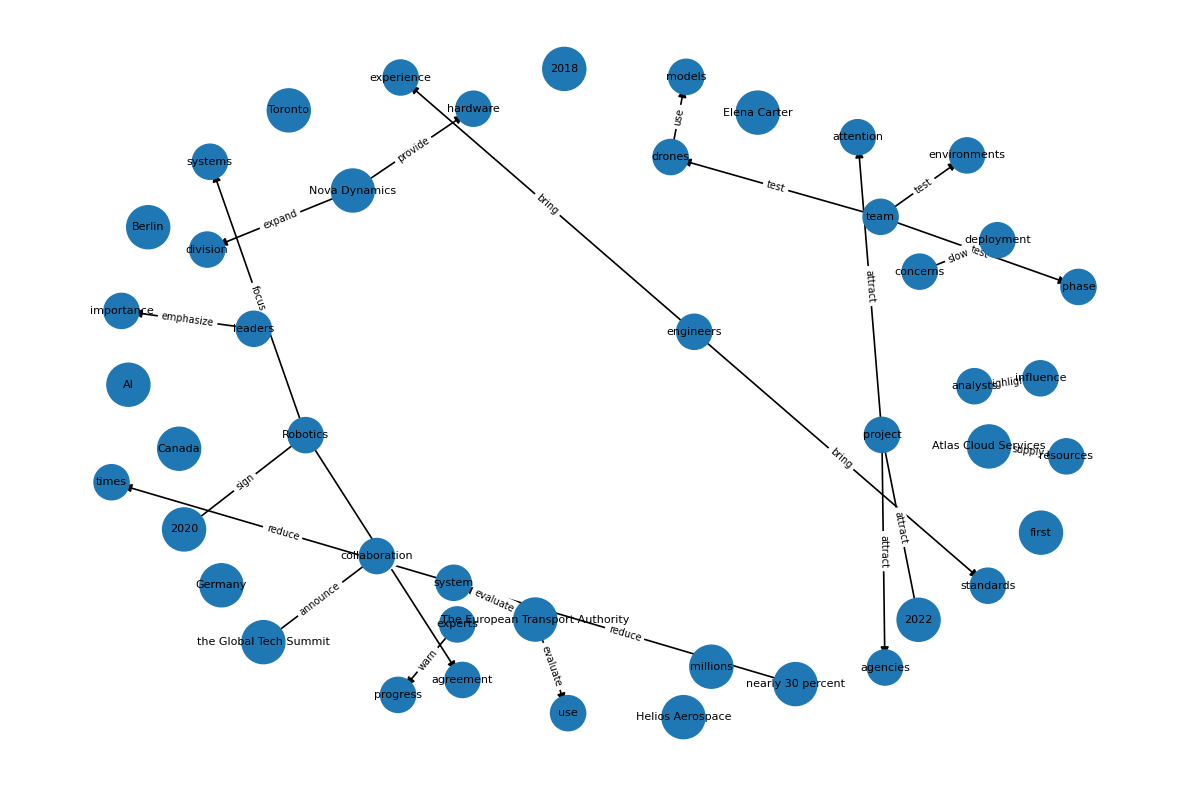

In [7]:
G = build_knowledge_graph(TEXT, nlp=nlp)
draw_knowledge_graph(G, max_nodes=60, show_edge_labels=True)
plt.show()

In [28]:
# LLM Graph (Inference Providers style: InferenceClient)
# Based on HF guide: InferenceClient(provider="auto", api_key=os.environ["HF_TOKEN"]) :contentReference[oaicite:1]{index=1}

!pip -q install huggingface_hub networkx

import os, json, re
import networkx as nx
from kaggle_secrets import UserSecretsClient
from huggingface_hub import InferenceClient

user_secrets = UserSecretsClient()

def generate_knowledge_graph_hf_providers(
    text: str,
    model: str = "mistralai/Mistral-7B-Instruct-v0.2",
    provider: str = "auto",          # "auto" recommended for fallback :contentReference[oaicite:2]{index=2}
    max_tokens: int = 4096,
    temperature: float = 0.2,
) -> nx.MultiDiGraph:
    """
    KG extraction using Hugging Face Inference Providers via huggingface_hub.InferenceClient.

    Requires Kaggle Secret:
      HF_TOKEN
    """

    hf_token = user_secrets.get_secret("HF_TOKEN")
    if not hf_token:
        raise RuntimeError("HF_TOKEN not found. Add it in Kaggle Secrets as HF_TOKEN.")

    # Inference Providers client (provider can be "auto" or a specific provider) :contentReference[oaicite:3]{index=3}
    client = InferenceClient(provider=provider, api_key=hf_token)

    system_prompt = (
        "You are an information extraction system that generates a DETAILED knowledge graph from text.\n"
        "Primary goal: MAXIMIZE RECALL. Do not summarize or select only main facts.\n"
        "Rules:\n"
        "- Extract ALL entities explicitly mentioned, including organizations, people, locations, events, technologies, projects, concepts, risks, regulations, metrics, and domains.\n"
        "- Also extract meaningful noun phrases as CONCEPT entities (e.g., autonomous delivery drones, machine learning models, distributed cloud platform, ethical concerns).\n"
        "- Normalize entity names consistently (same entity = same string).\n"
        "- Extract EVERY explicit relation in the text, not only important ones.\n"
        "- Create separate relations for actions, attributes, locations, time, quantities, impacts, and stakeholders.\n"
        "- Relations must be directional and specific, using concise snake_case verb phrases.\n"
        "- Do NOT collapse multiple facts into one relation.\n"
        "- Avoid weak relations like 'is' or 'has' unless they express a real property.\n"
        "- Include years and quantities as separate relations or edge attributes when mentioned.\n"
        "- Use only facts stated in the text. Do NOT infer or guess.\n"
        "- Output ONLY valid JSON (no markdown, no commentary).\n"
    )


    user_prompt = f"""
    Extract a DETAILED knowledge graph from the text below.
    
    Return ONLY JSON in this schema:
    
    {{
      "entities": [
        {{
          "name": "string",
          "type": "PERSON | ORG | GPE | EVENT | PROJECT | TECHNOLOGY | METRIC | REGULATION | RISK | DOMAIN | CONCEPT",
          "description": "string"
        }}
      ],
      "relations": [
        {{
          "source": "entity name",
          "target": "entity name",
          "relation": "verb_phrase_snake_case",
          "description": "string"
        }}
      ]
    }}
    
    Text:
    {text}
    
    JSON:
    """.strip()

    # Chat completion style call (Inference Providers has a "Chat Completion" task section;
    # InferenceClient supports chat.completions on supported providers/models)
    resp = client.chat.completions.create(
        model=model,
        messages=[
            {"role": "system", "content": system_prompt},
            {"role": "user", "content": user_prompt},
        ],
        temperature=temperature,
        max_tokens=max_tokens,
    )

    content = resp.choices[0].message.content

    # Extract JSON safely (in case model adds extra text)
    m = re.search(r"\{[\s\S]*\}", content)
    if not m:
        raise ValueError(
            "No JSON found in model output. Try:\n"
            "- lower temperature\n"
            "- increase max_tokens\n"
            "- switch to a different model that supports chat completions\n"
        )

    data = json.loads(m.group())

    # Build graph
    G = nx.MultiDiGraph()

    for ent in data.get("entities", []):
        name = (ent.get("name") or "").strip()
        if not name:
            continue
        G.add_node(
            name,
            type=(ent.get("type") or "UNKNOWN").strip(),
            description=(ent.get("description") or "").strip(),
        )

    for rel in data.get("relations", []):
        s = (rel.get("source") or "").strip()
        t = (rel.get("target") or "").strip()
        if not s or not t:
            continue

        if s not in G:
            G.add_node(s, type="UNKNOWN", description="")
        if t not in G:
            G.add_node(t, type="UNKNOWN", description="")

        G.add_edge(
            s,
            t,
            relation=(rel.get("relation") or "").strip(),
            description=(rel.get("description") or "").strip(),
        )

    # Helpful metadata
    G.graph["hf_model"] = model
    G.graph["hf_provider"] = provider
    return G


In [29]:
TEXT = """
In 2018, Orion Robotics partnered with Nova Dynamics to develop autonomous delivery drones.
The collaboration was announced at the Global Tech Summit in Berlin, where industry analysts
highlighted the growing influence of artificial intelligence in logistics.

Orion Robotics, founded by Elena Carter, focuses on robotic navigation systems and real-time
decision-making algorithms. Nova Dynamics, a multinational engineering firm headquartered
in Toronto, provides advanced sensor hardware and embedded control units.

During the first phase of the project, the joint team tested prototype drones across urban
environments in Germany and Canada. The drones used machine learning models trained on
millions of flight simulations. Engineers reported that the system reduced delivery times
by nearly 30 percent.

In 2020, Orion Robotics signed a separate agreement with Atlas Cloud Services to migrate
its data infrastructure to a distributed cloud platform. Atlas Cloud Services supplies
scalable computing resources for AI startups and research labs worldwide.

Meanwhile, Nova Dynamics expanded its research division and hired several former employees
from Helios Aerospace. These engineers brought experience in aerospace safety standards
and regulatory compliance.

By 2022, the delivery drone project attracted attention from government agencies.
The European Transport Authority evaluated the system for potential use in emergency
medical logistics. Analysts predicted that similar technologies would soon be adopted
by healthcare providers and retail companies.

Despite rapid progress, experts warned that ethical concerns and airspace regulations
could slow deployment. Industry leaders emphasized the importance of transparent governance
and international cooperation.
"""

G = generate_knowledge_graph_hf_providers(TEXT, model="mistralai/Mistral-7B-Instruct-v0.2", provider="auto")
print("Model:", G.graph["hf_model"], "| Provider:", G.graph["hf_provider"])
print("Nodes:", G.number_of_nodes(), "Edges:", G.number_of_edges())
for u, v, d in list(G.edges(data=True)):
    print(f"{u} --[{d.get('relation')}]--> {v}")


Model: mistralai/Mistral-7B-Instruct-v0.2 | Provider: auto
Nodes: 36 Edges: 15
Orion Robotics --[partnered_with]--> Nova Dynamics
Orion Robotics --[signed_agreement_with]--> Atlas Cloud Services
Orion Robotics --[developed]--> Prototype drones
Orion Robotics --[evaluated_by]--> European Transport Authority
Elena Carter --[founded]--> Orion Robotics
Nova Dynamics --[hired_employees_from]--> Helios Aerospace
Global Tech Summit --[highlighted]--> Industry analysts
Prototype drones --[tested_in]--> Urban environments in Germany and Canada
Prototype drones --[used_machine_learning_models_trained_on]--> Machine learning models
Prototype drones --[used_models_trained_on]--> Millions of flight simulations
Prototype drones --[reduced_delivery_times_by]--> Delivery times
Industry leaders --[emphasized_importance_of]--> Transparent governance
Industry leaders --[emphasized_importance_of]--> International cooperation
Experts --[warned_about]--> Ethical concerns
Experts --[warned_about]--> Airspace

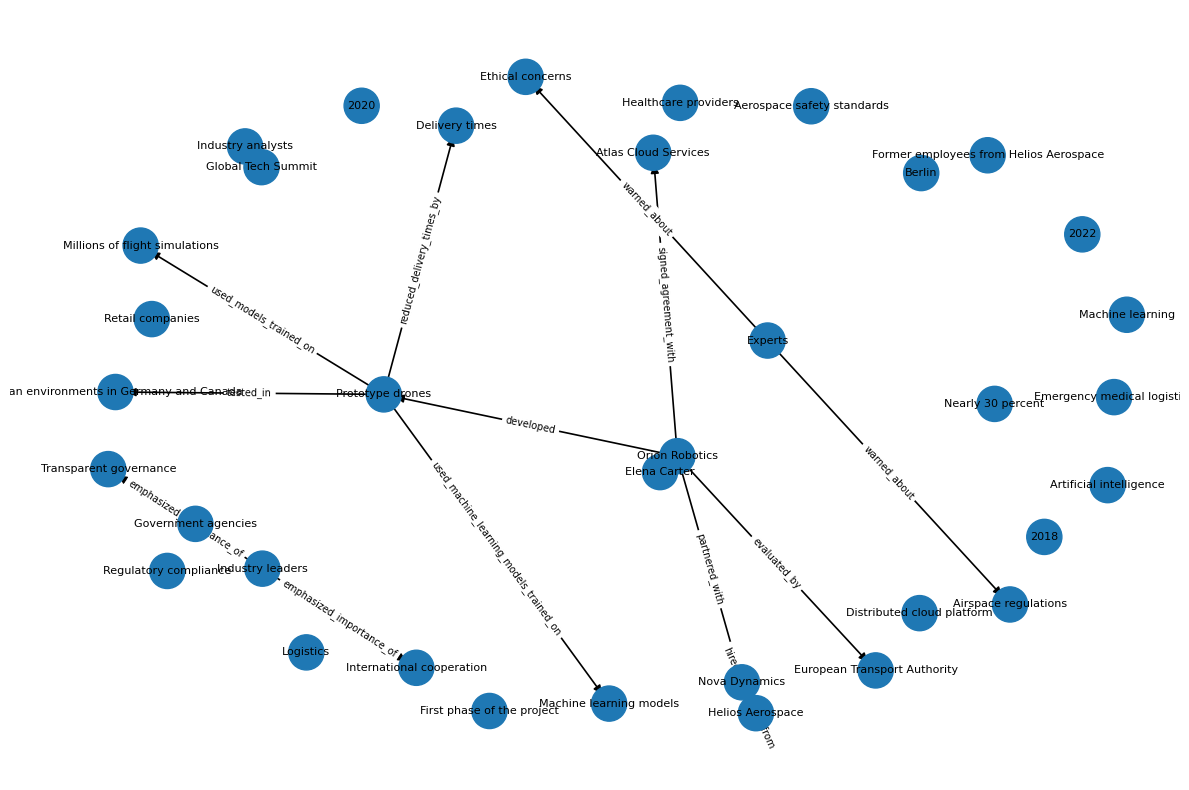

In [30]:
draw_knowledge_graph(G, max_nodes=60, show_edge_labels=True)
plt.show()